In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512 * 8 * 8, 1024),
            nn.ReLU(),
            nn.Linear(1024, 350)
        )
        self.decoder = nn.Sequential(
            nn.Linear(175, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (512, 8, 8)),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + beta * KLD

In [4]:
from ignite.engine import Engine, Events
from ignite.metrics import FID, InceptionScore
from ignite.contrib.handlers import ProgressBar
import PIL.Image as Image
from torchvision.transforms import ToPILImage, ToTensor


In [5]:
def train(model, dataloader, optimizer, scheduler, num_epochs=20):
    model.to(device)
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for data, _ in dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = vae_loss(recon_batch, data, mu, logvar, 0.1)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        scheduler.step()
        avg_loss = total_loss / len(dataloader.dataset)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch + 1}, Total Loss: {avg_loss}')

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss Across Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_loss_curve.png')
    plt.show()

    return train_losses

In [6]:
def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = ToPILImage()(img)
        resized_img = pil_img.resize((299, 299), Image.BILINEAR)
        arr.append(ToTensor()(resized_img))
    return torch.stack(arr)

def evaluation_step(engine, batch):
    model = engine.state.model
    with torch.no_grad():
        noise = torch.randn(batch[0].size(0), 175).to(device)
        model.eval()
        fake_batch = model.decoder(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

evaluator = Engine(evaluation_step)

fid_metric = FID(device=device)
is_metric = InceptionScore(device=device, output_transform=lambda x: x[0])
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

ProgressBar().attach(evaluator)

fid_values = []
is_values = []

def log_training_results(engine):
    evaluator.state.model = engine.state.model
    evaluator.run(dataloader)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/{epochs}] Metric Scores")
    print(f"*   FID : {fid_score:.6f}")
    print(f"*    IS : {is_score:.6f}")

c:\Users\herb0\AppData\Local\Programs\Python\Python312\Lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Epoch 1, Total Loss: 1646.0759650892248
Epoch 2, Total Loss: 1229.2894533918204
Epoch 3, Total Loss: 922.8626248719262
Epoch 4, Total Loss: 705.7855297984972
Epoch 5, Total Loss: 581.530059314165
Epoch 6, Total Loss: 511.6110793150188
Epoch 7, Total Loss: 444.1876053940403
Epoch 8, Total Loss: 411.74859919313525
Epoch 9, Total Loss: 374.7797531378074
Epoch 10, Total Loss: 351.3166237085895
Epoch 11, Total Loss: 318.3011641372097
Epoch 12, Total Loss: 312.22657984332307
Epoch 13, Total Loss: 308.2808200857027
Epoch 14, Total Loss: 306.5051793166197
Epoch 15, Total Loss: 303.05296517460727
Epoch 16, Total Loss: 300.4081410892674
Epoch 17, Total Loss: 297.54340833653515
Epoch 18, Total Loss: 294.4617049420466
Epoch 19, Total Loss: 292.35749358297045
Epoch 20, Total Loss: 289.82701235911884
Epoch 21, Total Loss: 287.29447061507426
Epoch 22, Total Loss: 286.53633392834274
Epoch 23, Total Loss: 285.9886824811091
Epoch 24, Total Loss: 286.5304305279841
Epoch 25, Total Loss: 285.42547440659155

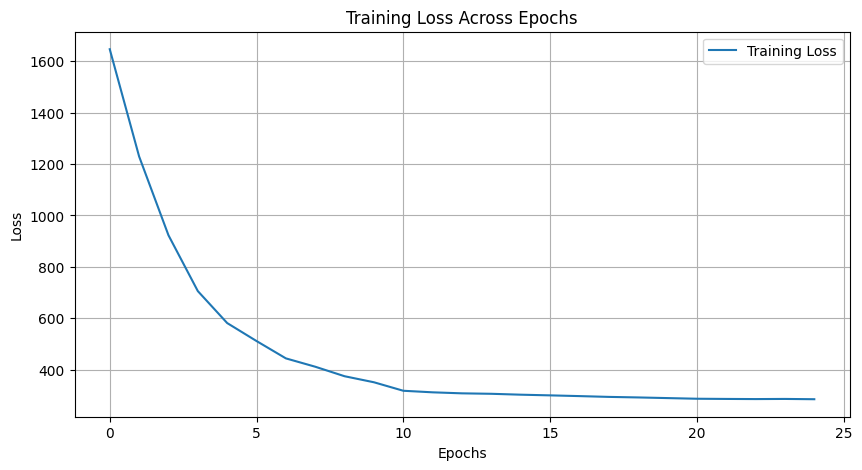

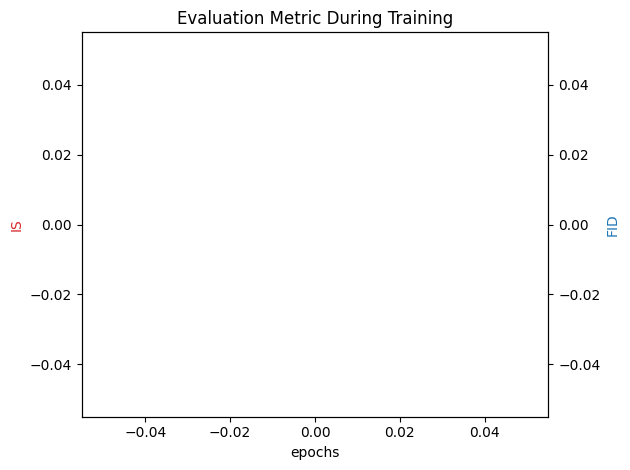

In [7]:
dataset = datasets.ImageFolder(root='chest_xray/chest_xray', transform=transform)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 25
trainer = Engine(lambda engine, batch: None)
trainer.state.model = model
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_training_results)

train_losses = train(model, dataloader, optimizer, scheduler, epochs)
trainer.run()
fig, ax1 = plt.subplots()
plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()
plt.show()

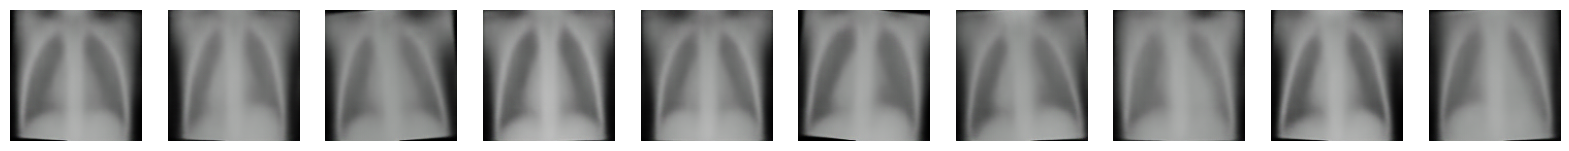

In [9]:
def generate_images(model, num_images=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, 175).to(device)
        generated_images = model.decoder(z)

    return generated_images

generated_images = generate_images(model, num_images=10)
generated_images = generated_images.cpu()

generated_images = generated_images.numpy()
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 4))
for ax, img in zip(axes, generated_images):
    img = img.reshape(3, 128, 128).transpose(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.show()